# Report: Ex1 - ZooScanNet in the cloud

## Tore Aadland

Prior works:
http://benanne.github.io/2015/03/17/plankton.html
https://www.kaggle.com/c/datasciencebowl/discussion

Training imagenet fast and cheaply: https://www.fast.ai/2018/04/30/dawnbench-fastai/

First lets load required modules:

In [1]:
import numpy as np
import random as rn
from dotenv import load_dotenv
import os
from skimage import io
from skimage.transform import resize, rotate
from skimage.util import pad
import matplotlib.pyplot as plt
from keras.utils import to_categorical, plot_model

import itertools

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate, Reshape, Flatten
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger

from sklearn.metrics import confusion_matrix
# import tensorflow as tf

import datetime
import time
import threading
load_dotenv()

C:\Users\Tore\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


True

 Then seed the random number generators to make results reproducible:

In [2]:
rn.seed(42)
np.random.seed(42)

Lets load some example data to get started and add some data augmentation increase the size of the training data.

In [3]:
datafolder = os.getenv("DATAFOLDER")
outputfolder = os.getenv("OUTPUTFOLDER")
imgfolder = os.path.join(datafolder, 'ZooScanSet','imgs')

In [4]:
# Code from:
# https://github.com/keras-team/keras/issues/1638

class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self): # Py3
        with self.lock:
            return next(self.it)

    def next(self):     # Py2
        with self.lock:
            return self.it.next()


def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

Need some way of propagating the size of the image that is invariant to rotations. I am unhappy about the rigidity of the default ImageDataGenerator. I make my own custom data generator.

In [5]:
# See: http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rotate
# For additional possible transformations.

def make_square(image, mode='constant'):
    max_dim = max(image.shape)
    pads = ((int((max_dim-image.shape[0])/2),
            int((max_dim-image.shape[0])/2)),
            (int((max_dim-image.shape[1])/2),
            int((max_dim-image.shape[1])/2)))
    if (mode=='constant'):
        image = pad(image,pads , mode=mode, constant_values=255)
    else:
        image = pad(image,pads , mode=mode)
    return resize(image, (224,224), mode=mode)

def augment_image(image):
    if(np.random.choice([True, False])):
        image = np.flip(image, axis=1)
    max_dim = max(image.shape)
    pads = ((int((max_dim-image.shape[0])/2),
            int((max_dim-image.shape[0])/2)),
            (int((max_dim-image.shape[1])/2),
            int((max_dim-image.shape[1])/2)))
    image = pad(image,pads , mode='constant', constant_values=255)
    angle = np.random.random_integers(0,359)
    resize_var = np.random.choice([True, False])
    image = rotate(image, angle, resize=resize_var, mode=np.random.choice(['symmetric', 'reflect', 'wrap', 'edge']))
    return make_square(image, mode='symmetric')

class MyGenerators(object):
    def __init__(self, path, val_fac=10, batch_size=16, validation_size=64, target_size=(224,224)):
        self.path = path
        self.val_fac = val_fac
        self.batch_size = batch_size
        self.validation_size = validation_size
        self.target_size = target_size
        
        self.labels = os.listdir(path)
        self.number_labels = len(self.labels)
        self.number_label_elements = {}
        self.label_paths = {}
        self.label_len = {}
        self.images = {}
        self.labels_to_classify = []
        for i, l in enumerate(self.labels):
            self.label_paths[i] = os.path.join(self.path, l)
            self.images[i] = (os.listdir(self.label_paths[i]))
            self.label_len[i] = len(self.images[i])
    
    @threadsafe_generator
    def training_generator(self):
        while(True):
            output_list = []
            output_labels = []
            while not len(output_list) == self.batch_size:
                random_label = np.random.choice(self.number_labels)
                random_image = np.random.choice(self.label_len[random_label])
                if random_image % self.val_fac == 0:
                    continue
                output_labels.append(random_label)
                output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
            output_images = [io.imread(fp) for fp in output_list]
            output_statistics = [[max(image.shape)/1024.0,np.sum(image==255)/(max(image.shape)**2)] for image in output_images]
            output_images = [augment_image(image).reshape(224,224,1) for image in output_images]
            yield ([np.stack(output_images), 
                  np.stack(output_statistics)], 
                  to_categorical(np.stack(output_labels), num_classes = self.number_labels))
    
    @threadsafe_generator
    def validation_generator(self):
        while(True):
            output_list = []
            output_labels = []
            while not len(output_list) == self.validation_size:
                random_label = np.random.choice(self.number_labels)
                random_image = 2*self.val_fac*np.random.choice(int(self.label_len[random_label]/(2*self.val_fac)))
                assert random_image % self.val_fac == 0
                assert random_image < len(self.images[random_label])
                output_labels.append(random_label)
                output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
            output_images = [io.imread(fp) for fp in output_list]
            output_statistics = [[max(image.shape)/1024.0,np.sum(image==255)/(max(image.shape)**2)] for image in output_images]
            output_images = [make_square(image).reshape(224,224,1) for image in output_images]
            yield ([np.stack(output_images), 
                  np.stack(output_statistics)], 
                  to_categorical(np.stack(output_labels), num_classes = self.number_labels))
    
    @threadsafe_generator
    def test_generator(self):
        while(True):
            output_list = []
            output_labels = []
            while not len(output_list) == self.validation_size:
                random_label = np.random.choice(self.number_labels)
                random_image = self.val_fac*np.random.choice(-1+2*int(self.label_len[random_label]/(2*self.val_fac)))
                assert random_image % (self.val_fac-1) == 0
                output_labels.append(random_label)
                output_list.append(os.path.join(self.label_paths[random_label], self.images[random_label][random_image]))
            output_images = [io.imread(fp) for fp in output_list]
            output_statistics = [[max(image.shape)/1024.0,np.sum(image==255)/(max(image.shape)**2)] for image in output_images]
            output_images = [make_square(image).reshape(224,224,1) for image in output_images]
            yield ([np.stack(output_images), 
                  np.stack(output_statistics)], 
                  to_categorical(np.stack(output_labels), num_classes = self.number_labels))

@threadsafe_generator            
def make_image_generator(gen):
    while True:
        res = next(gen)
        yield res[0][0], res[1]

@threadsafe_generator
def make_stat_generator(gen):
    while True:
        res = next(gen)
        yield res[0][1], res[1]

A helper function to train and save models:

In [6]:
def fit_and_save_model(name, model, train_gen, validation_gen, 
                       steps_per_epoch = 10, validation_steps=10, epochs=10, img_input=True):
    modeloutputfolder = os.path.join(outputfolder, name, datetime.datetime.now().strftime("%Y-%m-%d-%H-%M"))
    if not os.path.exists(modeloutputfolder):
        os.makedirs(modeloutputfolder)
    
    cbs=[ModelCheckpoint(filepath=os.path.join(modeloutputfolder,'model_fitted.h5'), verbose=1, save_best_only=True),
         EarlyStopping(monitor='val_loss', patience=10),
         CSVLogger(os.path.join(modeloutputfolder,'model_history.csv'), separator=',', append=False)]
         
    start_time = time.time()
    history = model.fit_generator(train_gen,
                             steps_per_epoch=steps_per_epoch,
                             validation_data=validation_gen,
                             validation_steps=validation_steps,
                             epochs=epochs, 
                            callbacks=cbs)
    end_time = time.time()
    
    
    plot_model(model, 
           to_file=os.path.join(modeloutputfolder,'model_visualized.png'),
           show_shapes=True,
           show_layer_names=True)
    
    print("It has the following training history:")
    plt.figure(figsize=(10,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training data loss')
    plt.plot(history.history['val_loss'], label='Validation data loss')
    plt.legend()
    plt.title("Loss")
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Training data accuracy')
    plt.plot(history.history['val_acc'], label='Validation data accuracy')
    plt.legend()
    plt.title("Accuracy")
    plt.suptitle("Model performance - {}".format(name))
    
    plt.savefig(os.path.join(modeloutputfolder,'model_history.png'))
    plt.show()
    
    score = model.evaluate_generator(validation_gen, steps=validation_steps)
    print("It has the following performance:")
    summary = "Validation loss: {}\nValidation accuracy: {}\nTraining time: {}".format(score[0], score[1], end_time-start_time)
    print(summary)
    
    with open(os.path.join(modeloutputfolder,'model_score.txt'), 'w+') as f:
        f.write(summary)

    print("It has the following confusion matrix:")
    img_vals = []
    stat_vals = []
    y_vals = []
    for _ in range(10):
        x, y = next(validation_gen)
        if len(x) == 2:
            img_vals.append(x[0])
            stat_vals.append(x[1])
        else:
            img_vals.append(x)
        y_vals.append(y)
    if stat_vals:
        X_validation = [np.concatenate(img_vals), np.concatenate(stat_vals)]
    else:
        X_validation = [np.concatenate(img_vals)]
    y_target = np.concatenate(y_vals)
    y_predicted = np.argmax(model.predict(X_validation), axis= 1)
    y_true = np.argmax(y_target, axis= 1)
    cm = confusion_matrix(y_true, y_predicted)
    for i in range(len(cm)):
        cm[i,i] = 0
    plt.figure(figsize=(8,6))
    plt.imshow(cm, cmap="Greys")
    plt.xticks(range(max(y_true+1)))
    plt.yticks(range(max(y_true+1)))
    plt.title("Confusion matrix")
    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.savefig(os.path.join(modeloutputfolder,'model_confusion_matrix.png'))
    plt.show()
    
    if img_input:
        print("These are examples of misclassified features:")
        plt.figure(figsize=(10,10))
        #plt.subplot(3, 3, 1)
        plt.suptitle("Misclassified images - Model")
        poss_indexes = np.argwhere(y_predicted-y_true != 0)
        indexes = poss_indexes[:9]

        for i, index in enumerate(indexes.ravel()):
            plt.subplot(3, 3, i+1)
            plt.imshow(X_validation[0][index].reshape(224,224), cmap="Greys_r")
            plt.title("A {} misclassified as {}".format(y_true[index], y_predicted[index]))
        plt.savefig(os.path.join(modeloutputfolder,'model_misclassified_features.png'))
        plt.show()

Initialize data generator:

In [7]:
dategen = MyGenerators(imgfolder, batch_size=16)

train_gen = dategen.training_generator()
validation_gen = dategen.validation_generator()

NUMBER_LABELS = dategen.number_labels

Class distribution:

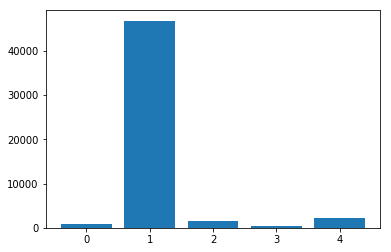

In [8]:
plt.bar(dategen.label_len.keys(), dategen.label_len.values())
plt.show()

Visualize training image, a quick check to see that input data is still sane:

C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead


<Figure size 432x288 with 0 Axes>

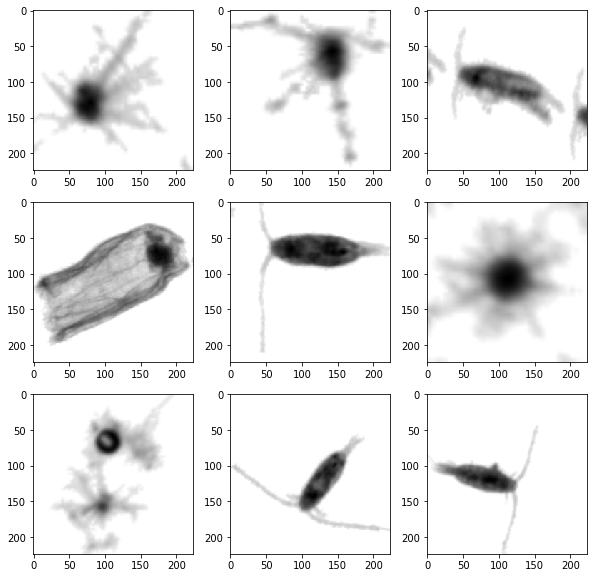

In [22]:
plt.clf()
plt.figure(figsize=(10,10))
j = 1
for i in next(train_gen)[0][0]:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i[:,:,0], cmap="gray")
    j += 1
plt.show()   

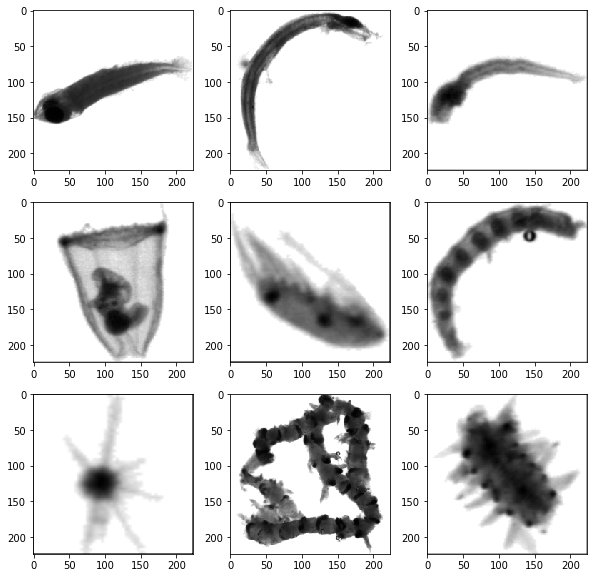

In [23]:
plt.figure(figsize=(10,10))
j = 1
for i in next(validation_gen)[0][0]:
    if j > 9:
        break
    plt.subplot(3, 3, j)
    plt.imshow(i[:,:,0], cmap="gray")
    j += 1
plt.show()  

Now, lets make a small convolutional model:

In [11]:
# Copy paste from:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
# Just to see if a simple model is better than pretrained network.

model = Sequential()
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3),, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3),, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu') )

And customize it through the functional API. First I need to resize my input data to be consistent with the InceptionV3 model:

In [12]:
inputs_image = Input(shape=(224,224,1))
x = model(inputs_image)
x = Dense(1024, activation='relu')(x)
outputs_image = Dense(1024, activation='relu')(x)
predictions_image = Dense(NUMBER_LABELS, activation='softmax', name="output")(outputs_image)

In [13]:
model_images = Model(inputs=inputs_image, outputs=predictions_image)
model_images.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10


C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead


10/10 [==============================] - 12s 1s/step - loss: 3.4213 - acc: 0.2625 - val_loss: 1.6278 - val_acc: 0.2547

Epoch 00001: val_loss improved from inf to 1.62775, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\model_images\2019-02-13-23-03\model_fitted.h5
Epoch 2/10
10/10 [==============================] - 8s 779ms/step - loss: 1.6123 - acc: 0.4562 - val_loss: 1.4707 - val_acc: 0.4250

Epoch 00002: val_loss improved from 1.62775 to 1.47070, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\model_images\2019-02-13-23-03\model_fitted.h5
Epoch 3/10
10/10 [==============================] - 5s 492ms/step - loss: 1.3667 - acc: 0.5438 - val_loss: 1.9436 - val_acc: 0.3094

Epoch 00003: val_loss did not improve from 1.47070
Epoch 4/10
10/10 [==============================] - 4s 393ms/step - loss: 1.2008 - acc: 0.5750 - val_loss: 1.1545 - val_acc: 0.5500

Epoch 00004: val_loss improved from 1.47070 to 1.15453, saving model to C:\Users\Tore\Dropbox\V2019\

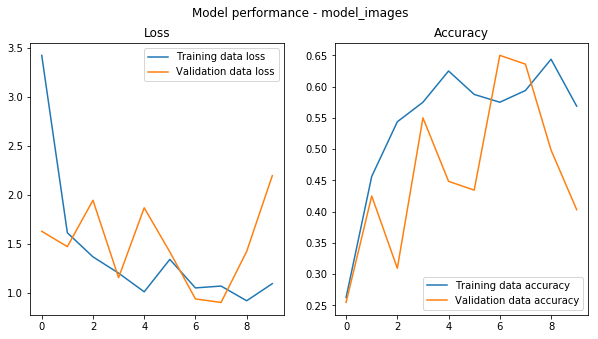

It has the following performance:
Validation loss: 2.176803195476532
Validation accuracy: 0.375
Training time: 73.59794068336487
It has the following confusion matrix:


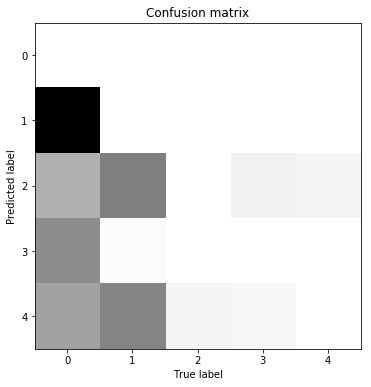

These are examples of misclassified features:


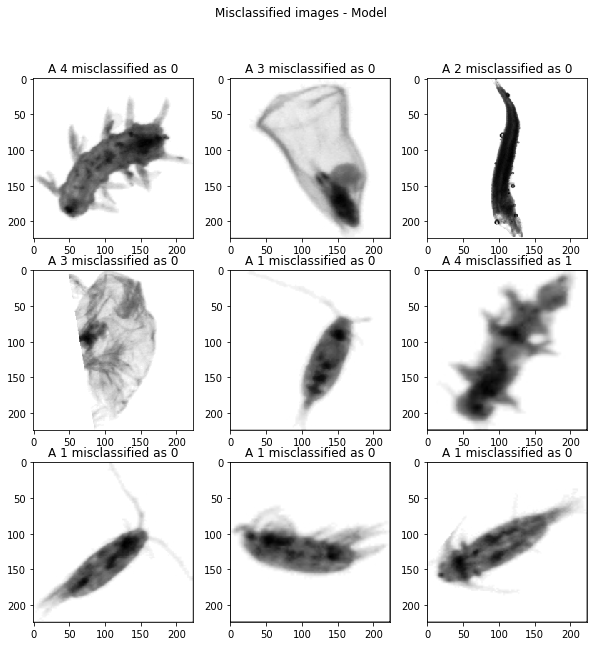

In [14]:
fit_and_save_model("model_images", model_images, make_image_generator(train_gen), make_image_generator(validation_gen))

Now we define a second model that analyses the imagestatistics:

In [15]:
inputs_stat = Input(shape=(2,))
x = Dense(16, activation='relu')(inputs_stat)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output_stat = Dense(16, activation='relu')(x)
predictions_stat = Dense(NUMBER_LABELS, activation='softmax', name="output")(output_stat)

In [16]:
model_stat = Model(inputs=inputs_stat, outputs=predictions_stat)
model_stat.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10


C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead


10/10 [==============================] - 8s 791ms/step - loss: 1.7200 - acc: 0.2250 - val_loss: 1.6000 - val_acc: 0.2391

Epoch 00001: val_loss improved from inf to 1.59996, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\model_stat\2019-02-13-23-04\model_fitted.h5
Epoch 2/10
10/10 [==============================] - 6s 587ms/step - loss: 1.6746 - acc: 0.2250 - val_loss: 1.5291 - val_acc: 0.3531

Epoch 00002: val_loss improved from 1.59996 to 1.52910, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\model_stat\2019-02-13-23-04\model_fitted.h5
Epoch 3/10
10/10 [==============================] - 9s 919ms/step - loss: 1.6214 - acc: 0.2188 - val_loss: 1.5311 - val_acc: 0.3328

Epoch 00003: val_loss did not improve from 1.52910
Epoch 4/10
10/10 [==============================] - 4s 411ms/step - loss: 1.5800 - acc: 0.2563 - val_loss: 1.4919 - val_acc: 0.3594

Epoch 00004: val_loss improved from 1.52910 to 1.49185, saving model to C:\Users\Tore\Dropbox\V2019\In

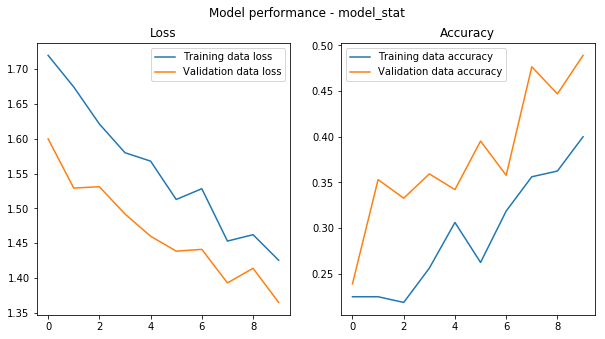

It has the following performance:
Validation loss: 1.361111843585968
Validation accuracy: 0.475
Training time: 63.813117027282715
It has the following confusion matrix:


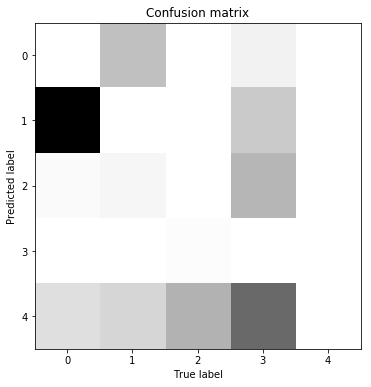

In [17]:
fit_and_save_model("model_stat", model_stat, make_stat_generator(train_gen), make_stat_generator(validation_gen), img_input=False)

Now I make a composite model:

In [18]:
x = Concatenate()([outputs_image, output_stat])
x = Dropout(0.2)(x)
predictions = Dense(NUMBER_LABELS, activation='softmax', name="output")(x)

composite_model = Model(inputs=[inputs_image, inputs_stat], outputs=predictions)

composite_model.compile(optimizer='rmsprop',
              loss="categorical_crossentropy", metrics=["accuracy"])

And fit the model to my training data:
TODO:
Make a multi-input mode that take both features_native and image data as input.
See: https://keras.io/getting-started/functional-api-guide/
Make custom datagenerator using: https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

In [24]:
fit_and_save_model("composite_model", composite_model, train_gen, validation_gen,
                  steps_per_epoch = 100, validation_steps=100, epochs=100 )

Epoch 1/100


C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead


100/100 [==============================] - 80s 799ms/step - loss: 0.7400 - acc: 0.7281 - val_loss: 1.1424 - val_acc: 0.7070

Epoch 00001: val_loss improved from inf to 1.14244, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\composite_model\2019-02-13-23-25\model_fitted.h5
Epoch 2/100
100/100 [==============================] - 71s 707ms/step - loss: 0.6925 - acc: 0.7469 - val_loss: 1.2942 - val_acc: 0.4827

Epoch 00002: val_loss did not improve from 1.14244
Epoch 3/100
100/100 [==============================] - 67s 668ms/step - loss: 0.6433 - acc: 0.7544 - val_loss: 1.1133 - val_acc: 0.5653

Epoch 00003: val_loss improved from 1.14244 to 1.11325, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\composite_model\2019-02-13-23-25\model_fitted.h5
Epoch 4/100
100/100 [==============================] - 75s 746ms/step - loss: 0.5917 - acc: 0.7756 - val_loss: 0.8173 - val_acc: 0.6967

Epoch 00004: val_loss improved from 1.11325 to 0.81734, saving model to C:\Us

KeyboardInterrupt: 

Epoch 1/10


C:\Users\Tore\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: This function is deprecated. Please call randint(0, 359 + 1) instead


10/10 [==============================] - 5s 507ms/step - loss: 0.3923 - acc: 0.8625 - val_loss: 0.6619 - val_acc: 0.7953

Epoch 00001: val_loss improved from inf to 0.66193, saving model to C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\composite_model\2019-02-14-00-02\model_fitted.h5
Epoch 2/10
10/10 [==============================] - 4s 430ms/step - loss: 0.7439 - acc: 0.7438 - val_loss: 1.5785 - val_acc: 0.6312

Epoch 00002: val_loss did not improve from 0.66193
Epoch 3/10
10/10 [==============================] - 5s 471ms/step - loss: 0.3936 - acc: 0.8250 - val_loss: 2.0773 - val_acc: 0.6516

Epoch 00003: val_loss did not improve from 0.66193
Epoch 4/10
10/10 [==============================] - 5s 490ms/step - loss: 0.6172 - acc: 0.7812 - val_loss: 3.4985 - val_acc: 0.4609

Epoch 00004: val_loss did not improve from 0.66193
Epoch 5/10
10/10 [==============================] - 5s 544ms/step - loss: 0.3240 - acc: 0.9062 - val_loss: 0.8077 - val_acc: 0.8203

Epoch 00005: val_loss did n

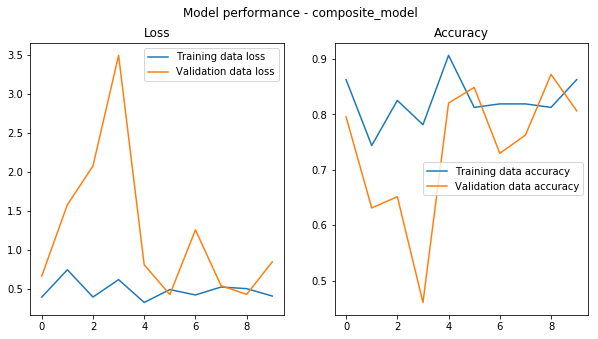

It has the following performance:
Validation loss: 0.7871567845344544
Validation accuracy: 0.7671875
Training time: 48.99483346939087
It has the following confusion matrix:


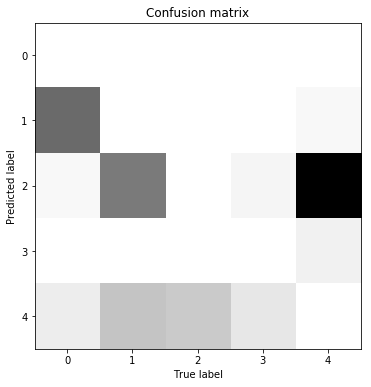

These are examples of misclassified features:


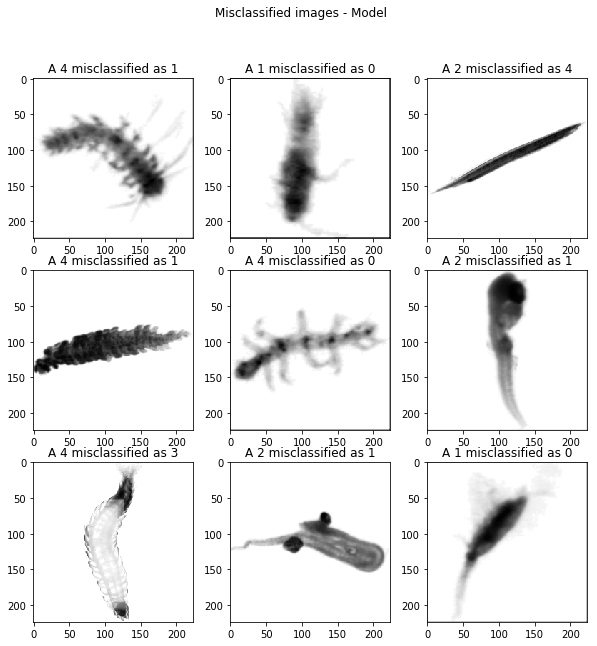

In [27]:
from keras.models import load_model
model = load_model(r"C:\Users\Tore\Dropbox\V2019\Inf368\inf368\output\composite_model\2019-02-13-23-25\model_fitted.h5")
fit_and_save_model("composite_model", model, train_gen, validation_gen,
                  steps_per_epoch = 10, validation_steps=10, epochs=10 )

In [20]:
# model.save('temp_model.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#from keras.models import load_model
#model = load_model('temp_model.h5')

The lower layer is: